In [8]:
import sys
sys.path.append("..")
import functools

import numpy as np
import torch
import scipy.linalg
import scipy.optimize
import matplotlib.pyplot as plt
from dict_minimize.torch_api import minimize
import functorch
import pyequion2

import tmcdiff

In [9]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [10]:
eqsys = pyequion2.EquilibriumBackend(["C", "Ca", "Na", "Cl"], from_elements=True, backend="torch", logbase="e",
                                     activity_model="DEBYE")

In [11]:
TK = 298.15
shear_velocity = 0.1
kinematic_viscosity = 1e-6
molal_balance = {'C':0.065, 'Ca':0.028, 'Na':0.075, 'Cl':0.056}

builder = tmcdiff.TransportBuilder(eqsys, TK, shear_velocity,
                           molal_balance, ["Calcite"],
                           kreaction="inf")
builder.make_grid(50, 5)
builder.set_species()

In [12]:
builder.set_initial_guess_from_bulk()

In [13]:
solsimple = builder.solve_lma(simplified=True);
solfull = builder.solve_lma(simplified=False);
solsimple.success, solfull.success

(True, True)

In [14]:
logcmu = builder.x.reshape(builder.nspecies, builder.ngrid).numpy()
logc = logcmu[:builder.nspecies, :]
c = np.exp(logc)
logc_t = torch.tensor(logc, dtype=torch.float)

Text(0.5, 0, '$y^+$')

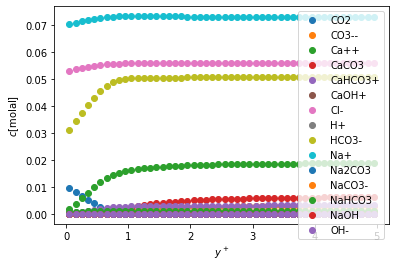

In [15]:
plt.figure()
for i in range(builder.nspecies):
    plt.plot(builder.ygrid, c[i, :], 'o', label=builder.species[i])
plt.legend()
plt.ylabel(r'$c$[molal]')
plt.xlabel(r'$y^+$')

Text(0.5, 0, '$y^+$')

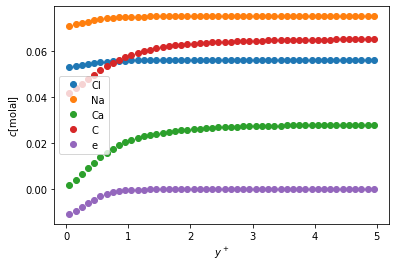

In [16]:
cel = builder.reduced_formula_matrix.numpy()@c
plt.figure()
for i, el in enumerate(eqsys.solute_elements + ['e']):
    plt.plot(builder.ygrid, cel[i, :], 'o', label=el)
plt.legend()
plt.ylabel(r'$c$[molal]')
plt.xlabel(r'$y^+$')

Text(0.5, 0, '$y^+$')

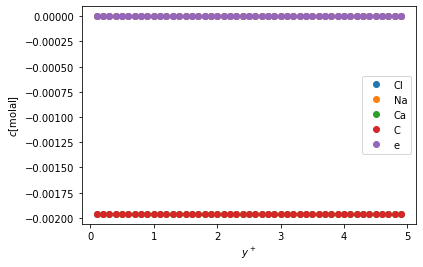

In [17]:
fluxes = builder.fluxes().detach().numpy()
yplot = builder.ypoints[1:-1].detach().numpy()
plt.figure()
for i, el in enumerate(eqsys.solute_elements + ['e']):
    plt.plot(yplot, fluxes[i, :], 'o', label=el)
plt.legend()
plt.ylabel(r'$c$[molal]')
plt.xlabel(r'$y^+$')

In [248]:
4/(1e-2)*builder.fluxes()

tensor([[ 6.6646e-06,  8.2600e-06,  5.8769e-06,  5.7761e-06,  4.2858e-06,
         -6.4416e-06, -8.1932e-06,  9.9411e-06,  4.2804e-06, -5.9772e-06,
         -2.1050e-06, -9.8062e-06,  1.1723e-05, -6.5610e-06, -1.3883e-05,
          3.4611e-05,  4.7454e-06,  2.5661e-06, -2.9176e-05,  2.9094e-05,
         -5.0136e-06,  4.7004e-05, -1.1938e-05, -6.7049e-05, -8.9124e-06,
          2.2800e-05,  6.3230e-05, -4.2502e-05, -8.2783e-05,  2.1131e-05,
          8.7177e-05, -1.2582e-04,  1.1556e-04,  1.1245e-04, -1.2851e-04,
          1.5374e-05, -1.1894e-04,  1.0911e-04,  2.9944e-05, -2.4256e-04,
          1.5396e-04,  1.0129e-05, -1.6122e-05,  1.8806e-04,  2.2795e-04,
         -3.5556e-04, -7.9265e-05, -2.2032e-04, -4.1008e-05],
        [-7.8369e-01, -7.8369e-01, -7.8369e-01, -7.8369e-01, -7.8369e-01,
         -7.8369e-01, -7.8369e-01, -7.8369e-01, -7.8369e-01, -7.8368e-01,
         -7.8369e-01, -7.8368e-01, -7.8369e-01, -7.8368e-01, -7.8369e-01,
         -7.8369e-01, -7.8369e-01, -7.8370e-01, -7